# Keras CIFAR10 CNN

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [79]:
from IPython.core.display import display, HTML
import random
color1 = ''.join(random.sample('def'*20, 6))
color2 = ''.join(random.sample('bcd'*20, 6))
print(color1, color2)
css = '''
<style>
div.cell {{background-color: #{color1};}}
div.running {{background-color: #{color2};}}
div.running.selected {{background-color: #{color2};}}
</style>'''.format(color1=color1, color2=color2)

display(HTML(css))

dddded cbdbcd


In [22]:
import _pickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename, astype='float'):
  """ load single batch of cifar """
  print(filename)
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(astype)
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT, n=1, astype='float'):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1, n+1):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f, astype=astype)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  # Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'), astype=astype)
  return Xtr, Ytr, # Xte, Yte


def get_CIFAR10_data(num_training=17000, num_validation=1000,
                     num_test=2000, astype='float'):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    import math
    cifar10_dir = '../CS231n_assignment2/cs231n/datasets'
    n = math.ceil((num_training + num_validation + num_test) / 10000)
    X_train, y_train = load_CIFAR10(cifar10_dir, n=int(n), astype=astype)

    # Subsample the data
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    mask = list(mask)
    X_test = X_train[mask]
    y_test = y_train[mask]

    mask = range(num_training, num_training + num_validation)
    mask = list(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]

    mask = range(num_training)
    mask = list(mask)
    X_train = X_train[mask]
    y_train = y_train[mask]

    print('X_train', X_train.shape)
    print('X_val', X_val.shape)
    print('X_test', X_test.shape)
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Transpose so that channels come first
    # Probe: on keras tf donot transpose
#     X_train = X_train.transpose(0, 3, 1, 2).copy()
#     X_val = X_val.transpose(0, 3, 1, 2).copy()
#     X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }


# data = get_CIFAR10_data(num_training=17000, num_validation=1000,
#                         num_test=2000, astype='float')
data = get_CIFAR10_data(num_training=19000, num_validation=1000,
                        num_test=0, astype=np.float32)

for k, v in data.items():
  print ('%s: ' % k, v.shape)

../CS231n_assignment2/cs231n/datasets\data_batch_1
../CS231n_assignment2/cs231n/datasets\data_batch_2
X_train (19000, 32, 32, 3)
X_val (1000, 32, 32, 3)
X_test (0, 32, 32, 3)
y_test:  (0,)
X_test:  (0, 32, 32, 3)
X_val:  (1000, 32, 32, 3)
y_train:  (19000,)
X_train:  (19000, 32, 32, 3)
y_val:  (1000,)


In [23]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
'''

# from keras.datasets import cifar10
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2

In [24]:

nb_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train = small_data['X_train']
# y_train = small_data['y_train']
# X_test = small_data['X_val']
# y_test = small_data['y_val']
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)

# print(Y_train)
# print(Y_test)
# X_train = X_train.astype('float32')
# X_val = X_val.astype('float32')
# X_train /= 255
# X_val /= 255

X_train shape: (19000, 32, 32, 3)
19000 train samples
1000 val samples


In [25]:
print(X_train.shape)
print(X_val.shape)

print(X_train[:,:,0][3:6])

# print('---------------')
# print(X_test[:,:,0][3:6])

(19000, 32, 32, 3)
(1000, 32, 32, 3)
[[[ -1.03191635e+02  -1.11183624e+02  -1.22515839e+02]
  [ -9.75225830e+01  -1.07361526e+02  -1.18295059e+02]
  [ -9.10914764e+01  -1.02659637e+02  -1.15196060e+02]
  [ -7.58604736e+01  -8.81172180e+01  -1.01220795e+02]
  [ -5.56489410e+01  -6.75599518e+01  -8.12158966e+01]
  [ -5.34769440e+01  -6.70024261e+01  -8.22591019e+01]
  [ -5.20064697e+01  -6.62296295e+01  -8.20706863e+01]
  [ -4.94136810e+01  -6.34225311e+01  -7.88145294e+01]
  [ -7.58319473e+01  -8.36188965e+01  -9.25825806e+01]
  [ -8.26925812e+01  -8.71659546e+01  -9.36735764e+01]
  [ -6.05527878e+01  -6.87287903e+01  -7.96869965e+01]
  [ -4.81848984e+01  -6.10641022e+01  -7.56065292e+01]
  [ -3.58395233e+01  -5.43564758e+01  -7.14849472e+01]
  [ -7.23089600e+00  -2.93845825e+01  -4.80352097e+01]
  [ -7.89036560e+00  -2.96864243e+01  -4.89381561e+01]
  [ -3.78748398e+01  -5.82983704e+01  -7.61677933e+01]
  [ -4.75882111e+01  -6.67631607e+01  -8.23419495e+01]
  [ -4.54785767e+01  -6.3438

In [38]:

# conv - relu - 2x2 max pool - affine - relu - affine - softmax
#     N, C, H, W = X.shape
#     crp_out, crp_cache = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
#     N, F, Hout, Wout = crp_out.shape
#     crp_out = crp_out.reshape((N, -1))  # N, F, Hout, Wout -> N, F*Hout*Wout
#     hidden_out, hidden_cache = affine_relu_forward(crp_out, W2, b2)
#     scores, scores_cache = affine_forward(hidden_out, W3, b3)

# def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
#              hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
  
#     conv_param = {'stride': 1, 'pad': int((filter_size - 1) / 2)}
#     pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}



# model = CustomConvNet(input_dim=(3, 32, 32),
#                       filters=(36,24,24),
#                       filter_size=3,
#                       hidden_dims=(500,300),
#                       num_classes=10,
#                       weight_scale=weight_scales.roll(),
#                       reg=regs.roll(),
#                       use_batchnorm=use_batchnorms.roll(),
#                       dtype=np.float32)
model = Sequential()
L2reg = l2(0.01)
adam = keras.optimizers.Adam(lr=0.001, 
                             beta_1=0.9, beta_2=0.999, 
                             epsilon=1e-08, decay=0.88)


def conv_factory(nb_filter=32, input_shape=None):
  if input_shape:
    model.add(Convolution2D(nb_filter, 3, 3, 
                            border_mode='same',
                            input_shape=input_shape, 
                            dim_ordering='tf',
                            W_regularizer=L2reg,
                           ))
  else:
    model.add(Convolution2D(nb_filter, 3, 3, 
                            border_mode='same', 
                            dim_ordering='tf',
                            W_regularizer=L2reg,
                           ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  

conv_factory(nb_filter=32, input_shape=X_train.shape[1:])
model.add(MaxPooling2D(pool_size=(2, 2)))
conv_factory(nb_filter=50)
model.add(MaxPooling2D(pool_size=(2, 2)))
conv_factory(nb_filter=98)
model.add(Flatten())
model.add(Dense(500, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(300, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=adam, #'rmsprop',  # rmsprop 貌似比 adam 有效的多
              metrics=['accuracy'])

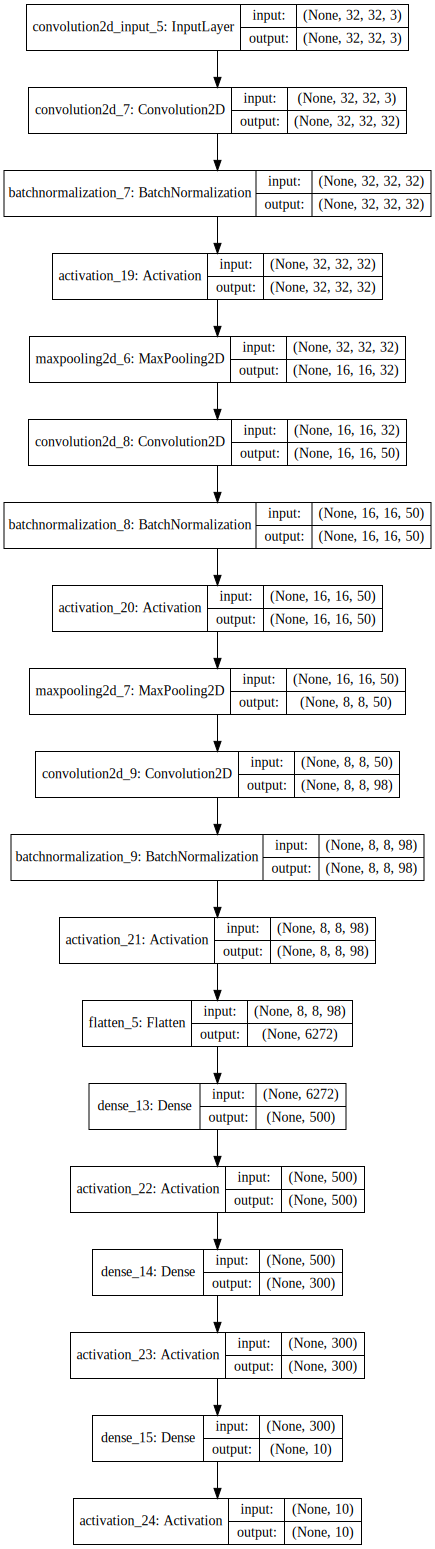

In [39]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

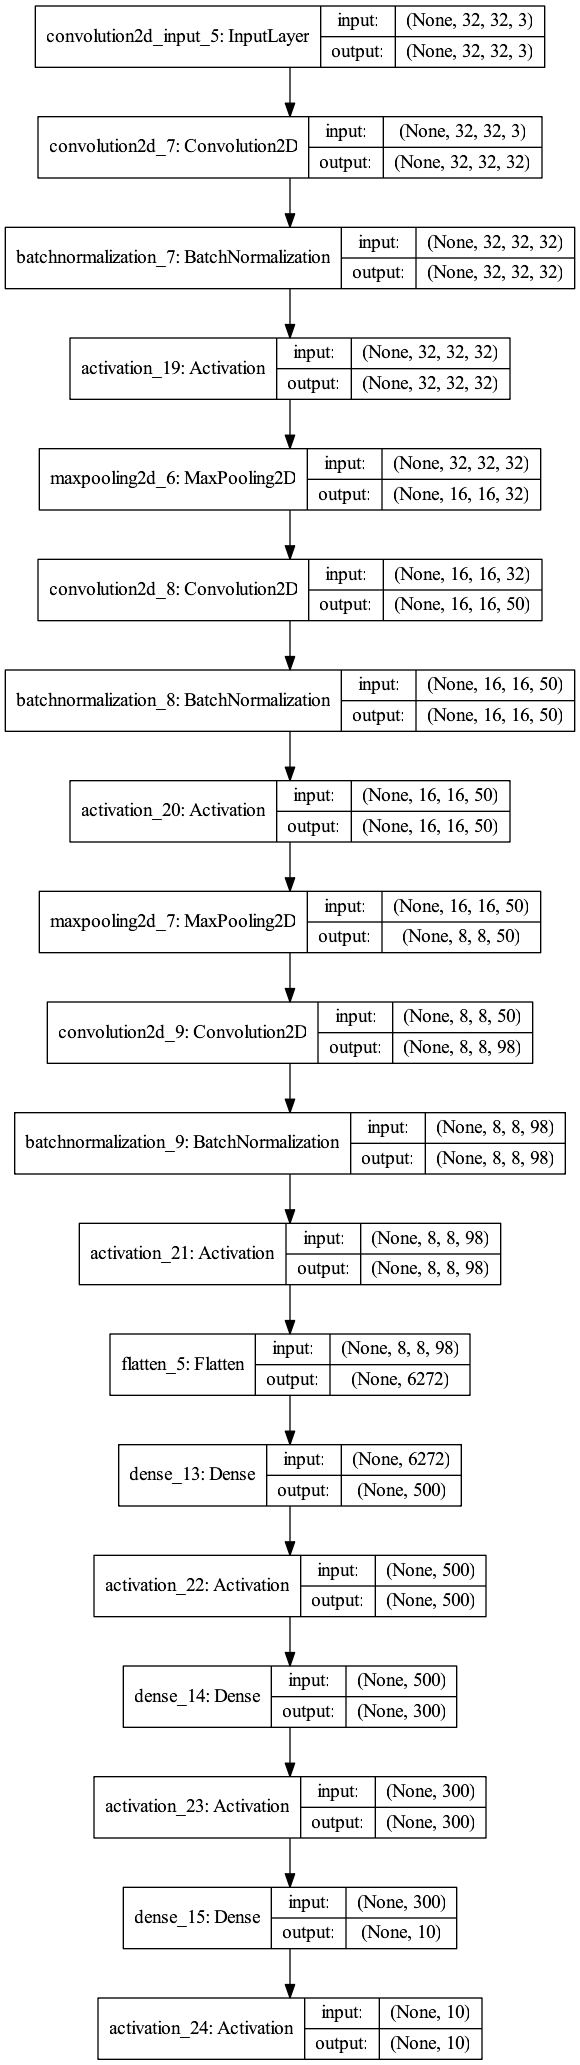

In [40]:
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='model.png')
from IPython.display import display, Image
display(Image('model.png', width=300))

In [89]:
print(model.to_yaml(), file=open('model.yaml', 'w'))
# %pycat model.yaml
print(model.summary())


# from models import model_from_yaml
# model = model_from_yaml(yaml_string)


filepath='model.h5'
# model.save_weights(filepath) # 将模型权重保存到指定路径，文件类型是HDF5（后缀是.h5）
# model.load_weights(filepath, by_name=False)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
batchnormalization_7 (BatchNorma (None, 32, 32, 32)    128         convolution2d_7[0][0]            
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 32, 32, 32)    0           batchnormalization_7[0][0]       
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 16, 16, 32)    0           activation_19[0][0]              
___________________________________________________________________________________________

In [86]:
data_augmentation = False

import platform
windows = platform.platform().startswith('Windows')

class BatchLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_loss = []
    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
batch_loss_history = BatchLossHistory()


adam_for_recompile = keras.optimizers.Adam(lr=0.00001, 
                                           beta_1=0.9, beta_2=0.999, 
                                           epsilon=1e-08, decay=0.88)
# try recompile
model.compile(loss='categorical_crossentropy',
              optimizer=adam_for_recompile, 
              metrics=['accuracy'])


hist = model.fit(X_train[0:19000, :, :, :], Y_train[0:19000],
                 batch_size=batch_size,
                 nb_epoch=nb_epoch,
                 validation_data=(X_val, Y_val),
                 shuffle=True,
                 verbose=2 if windows else 1, 
                 callbacks=[batch_loss_history],
                 )


Train on 19000 samples, validate on 1000 samples
Epoch 1/3
183s - loss: 3.9860 - acc: 0.6899 - val_loss: 4.1769 - val_acc: 0.6170
Epoch 2/3
187s - loss: 3.9820 - acc: 0.6917 - val_loss: 4.1759 - val_acc: 0.6220
Epoch 3/3
179s - loss: 3.9807 - acc: 0.6919 - val_loss: 4.1754 - val_acc: 0.6200


In [72]:
# test

predict_classes = model.predict_classes(X_val, batch_size=200, verbose=2)
# print(predict_classes.shape)
# print(y_val.shape)
print(np.sum(predict_classes == y_val))

580


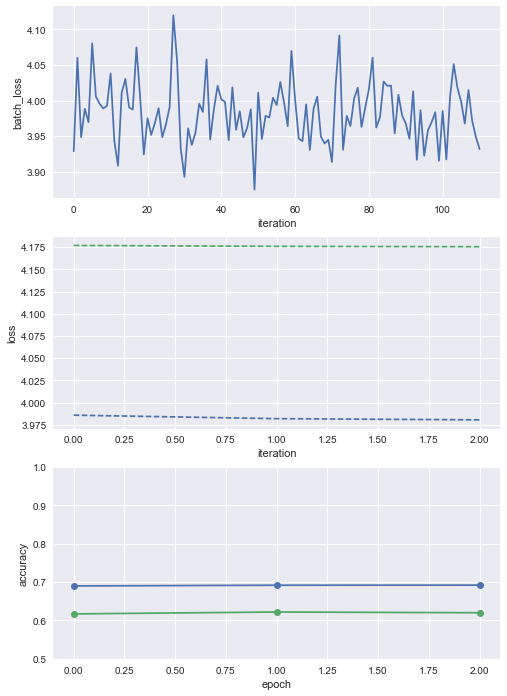

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# print(help(hist))
ax = plt.subplot(3, 1, 1)
plt.plot(batch_loss_history.batch_loss[3:], '-')
plt.xlabel('iteration')
plt.ylabel('batch_loss')

ax = plt.subplot(3, 1, 2)
plt.plot(hist.history['loss'], '--')
plt.plot(hist.history['val_loss'], '--')
plt.xlabel('iteration')
plt.ylabel('loss')

ax = plt.subplot(3, 1, 3)
plt.plot(hist.history['acc'], '-o')
plt.plot(hist.history['val_acc'], '-o')
# plt.plot(solver.val_acc_history, '-o')
# plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
ax.set_ylim([0.5, 1])

plt.show()